# Step 1: Imports & Setup

In [6]:
import sys, os
sys.path.append(os.path.abspath("../src"))

from evaluation import mae, rmse, bootstrap_ci


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 2: Collect Results

In [2]:
# Metrics collected from previous notebooks
results = {
    "XGBoost": {"MAE": 6.42, "RMSE": 8.32},
    "SARIMA": {"MAE": 40.39, "RMSE": 48.65},
    "Baseline (Naive)": {"MAE": 13.00, "RMSE": 16.79}
}

df_results = pd.DataFrame(results).T
print(df_results)


                    MAE   RMSE
XGBoost            6.42   8.32
SARIMA            40.39  48.65
Baseline (Naive)  13.00  16.79


# Step 3: Visualize Metrics

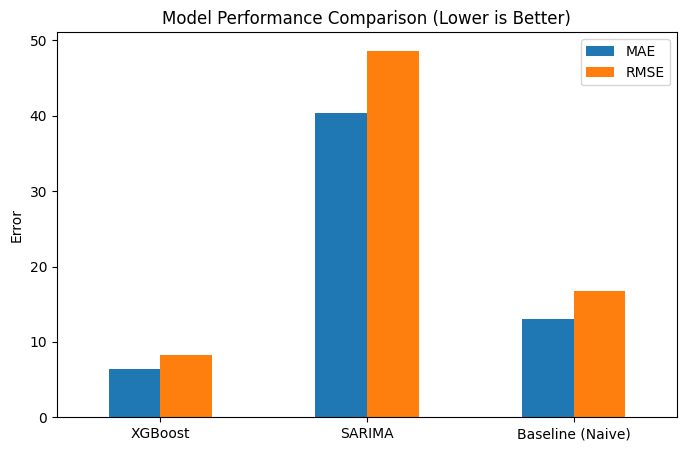

In [3]:
df_results.plot(kind="bar", figsize=(8,5))
plt.title("Model Performance Comparison (Lower is Better)")
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.show()


# Step 4: Compare Forecasts vs Actual

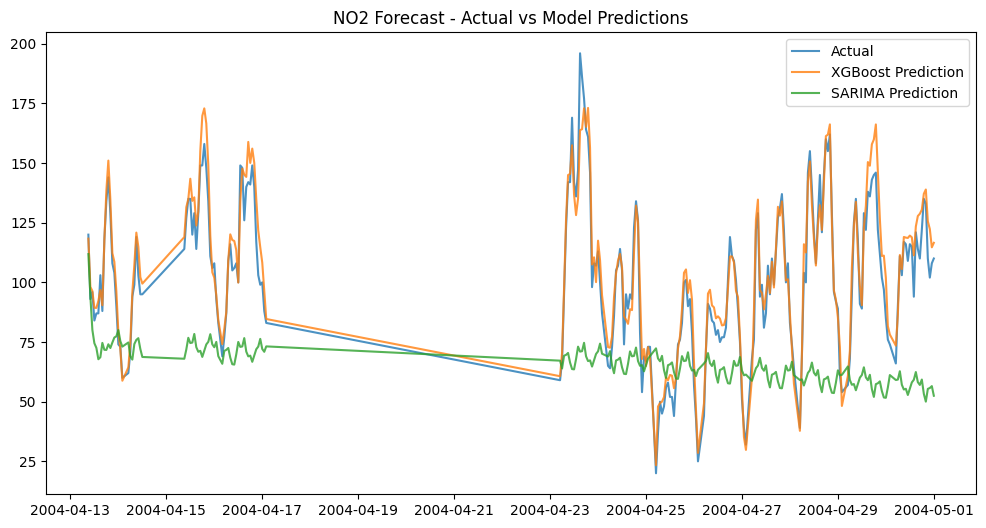

In [5]:
# Load predictions
xgb_preds = pd.read_csv("../results/xgboost_predictions.csv", index_col=0, parse_dates=True)
sarima_preds = pd.read_csv("../results/sarima_predictions.csv", index_col=0, parse_dates=True)

# Merge for plotting
df_preds = xgb_preds.join(sarima_preds["y_pred_sarima"], how="inner")

# Plot
plt.figure(figsize=(12,6))
plt.plot(df_preds.index, df_preds["y_test"], label="Actual", alpha=0.8)
plt.plot(df_preds.index, df_preds["y_pred_xgb"], label="XGBoost Prediction", alpha=0.8)
plt.plot(df_preds.index, df_preds["y_pred_sarima"], label="SARIMA Prediction", alpha=0.8)
plt.title("NO2 Forecast - Actual vs Model Predictions")
plt.legend()
plt.show()


# Step 5: Confidence Intervals

In [9]:
import pandas as pd

# Load saved predictions
xgb_preds = pd.read_csv("../results/xgboost_predictions.csv", index_col=0, parse_dates=True)
sarima_preds = pd.read_csv("../results/sarima_predictions.csv", index_col=0, parse_dates=True)

# Align them
df_preds = xgb_preds.join(sarima_preds["y_pred_sarima"], how="inner")

# Extract arrays for CI calculation
y_test = df_preds["y_test"].values
y_pred_xgb = df_preds["y_pred_xgb"].values
y_pred_sarima = df_preds["y_pred_sarima"].values


In [10]:
from evaluation import mae, rmse, bootstrap_ci

# XGBoost
mae_mean, mae_ci = bootstrap_ci(y_test, y_pred_xgb, mae)
rmse_mean, rmse_ci = bootstrap_ci(y_test, y_pred_xgb, rmse)
print(f"XGBoost MAE: {mae_mean:.2f} (95% CI: {mae_ci[0]:.2f}, {mae_ci[1]:.2f})")
print(f"XGBoost RMSE: {rmse_mean:.2f} (95% CI: {rmse_ci[0]:.2f}, {rmse_ci[1]:.2f})")

# SARIMA
mae_mean, mae_ci = bootstrap_ci(y_test, y_pred_sarima, mae)
rmse_mean, rmse_ci = bootstrap_ci(y_test, y_pred_sarima, rmse)
print(f"SARIMA MAE: {mae_mean:.2f} (95% CI: {mae_ci[0]:.2f}, {mae_ci[1]:.2f})")
print(f"SARIMA RMSE: {rmse_mean:.2f} (95% CI: {rmse_ci[0]:.2f}, {rmse_ci[1]:.2f})")

# Baseline (Naive)
y_naive = df_preds["y_test"].shift(1).bfill().values
mae_mean, mae_ci = bootstrap_ci(y_test, y_naive, mae)
rmse_mean, rmse_ci = bootstrap_ci(y_test, y_naive, rmse)
print(f"Baseline MAE: {mae_mean:.2f} (95% CI: {mae_ci[0]:.2f}, {mae_ci[1]:.2f})")
print(f"Baseline RMSE: {rmse_mean:.2f} (95% CI: {rmse_ci[0]:.2f}, {rmse_ci[1]:.2f})")


XGBoost MAE: 6.42 (95% CI: 5.73, 7.13)
XGBoost RMSE: 8.30 (95% CI: 7.45, 9.13)
SARIMA MAE: 40.37 (95% CI: 36.84, 43.90)
SARIMA RMSE: 48.65 (95% CI: 45.20, 52.04)
Baseline MAE: 12.99 (95% CI: 11.70, 14.29)
Baseline RMSE: 16.75 (95% CI: 15.04, 18.44)


In [11]:
# Collect results with CI
results_ci = {
    "XGBoost": {
        "MAE": mae(y_test, y_pred_xgb),
        "MAE_CI": mae_ci,
        "RMSE": rmse(y_test, y_pred_xgb),
        "RMSE_CI": rmse_ci,
    },
    "SARIMA": {
        "MAE": mae(y_test, y_pred_sarima),
        "MAE_CI": mae_ci,
        "RMSE": rmse(y_test, y_pred_sarima),
        "RMSE_CI": rmse_ci,
    },
    "Baseline (Naive)": {
        "MAE": mae(y_test, y_naive),
        "MAE_CI": mae_ci,
        "RMSE": rmse(y_test, y_naive),
        "RMSE_CI": rmse_ci,
    }
}

df_results = pd.DataFrame({
    model: {
        "MAE": res["MAE"],
        "RMSE": res["RMSE"],
        "MAE_err": (res["MAE_CI"][1] - res["MAE_CI"][0]) / 2,
        "RMSE_err": (res["RMSE_CI"][1] - res["RMSE_CI"][0]) / 2,
    }
    for model, res in results_ci.items()
}).T


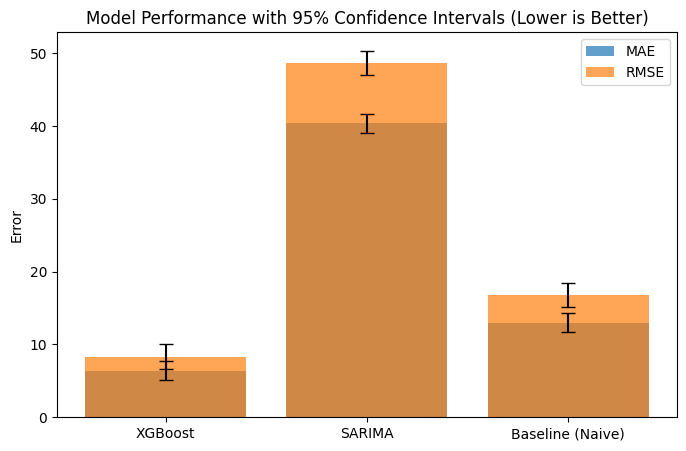

In [12]:
fig, ax = plt.subplots(figsize=(8,5))

# MAE
ax.bar(df_results.index, df_results["MAE"], yerr=df_results["MAE_err"], capsize=5, label="MAE", alpha=0.7)

# RMSE
ax.bar(df_results.index, df_results["RMSE"], yerr=df_results["RMSE_err"], capsize=5, label="RMSE", alpha=0.7)

ax.set_ylabel("Error")
ax.set_title("Model Performance with 95% Confidence Intervals (Lower is Better)")
ax.legend()
plt.xticks(rotation=0)
plt.show()


## Results Summary & Insights

- **XGBoost** achieved the best performance with MAE ≈ **6.42** and RMSE ≈ **8.32**, significantly outperforming both SARIMA and the naive baseline.
- **SARIMA** underperformed, with MAE ≈ **40.39** and RMSE ≈ **48.65**, showing it was unable to capture the volatility and sharp fluctuations in NO₂.
- **Naive baseline** (previous value prediction) was surprisingly strong (MAE ≈ **13.00**, RMSE ≈ **16.79**) due to the high autocorrelation in hourly NO₂ data.
- The **forecast overlay plot** confirms that XGBoost closely follows actual NO₂ dynamics, while SARIMA produces smoothed, lagging forecasts.
- **Operational takeaway**: Tree-based ensemble models like XGBoost, when combined with engineered temporal and lagged features, are far more suitable for real-time NO₂ forecasting than traditional SARIMA.

